# **Practica 2**
#### _Alberto García Doménech - Pablo Daurell Marina_ (Grupo 10)
***

## Parte 1 (Análisis de sentimiento)

In [126]:
import pandas as pd
import numpy as np

In [127]:
df = pd.read_csv("yelp_labelled.txt", sep='\t', names=['Data', 'Target'])
data = df.to_numpy()[:, 0]
target = df.to_numpy()[:, 1]
target = target.astype('int')

In [128]:
for i in range(10):
    print(data[i], target[i])

Wow... Loved this place. 1
Crust is not good. 0
Not tasty and the texture was just nasty. 0
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it. 1
The selection on the menu was great and so were the prices. 1
Now I am getting angry and I want my damn pho. 0
Honeslty it didn't taste THAT fresh.) 0
The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer. 0
The fries were great too. 1
A great touch. 1


In [129]:
print("Numero de opiniones negativas: ", np.count_nonzero(target == 0))
print("Numero de opiniones positivas: ", np.count_nonzero(target == 1))

Numero de opiniones negativas:  500
Numero de opiniones positivas:  500


In [130]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.25, random_state=0)

In [131]:
print("Training size: ", train_data.size)
print("Test size: ", test_data.size)

Training size:  750
Test size:  250


In [132]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data.any():
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

## A) Bolsas de palabras

In [133]:
# Diccionario vacío para ir guardando los resultados de cada clasificador
rates = {}

In [134]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### 1. Bolsa de palabras binaria y n-gramas (1,1) 

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta si una palabra aparece o no:

In [135]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,1)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [136]:
test_vector_data = vectorizer.transform(test_data)
print(test_vector_data.shape)

(250, 1510)


Con ayuda de la función ```write_terms```, previamente definida, podemos ver algunos ejemplos de como se han vectorizado los mensajes:

In [137]:
write_terms(feature_names, train_data, train_vector_data, 1)
write_terms(feature_names, train_data, train_vector_data, 10)
write_terms(feature_names, train_data, train_vector_data, 100)

Mensaje 1 : And the chef was generous with his time (even came around twice so we can take pictures with him).
Mensaje 1 vectorizado: ['came' 'chef' 'generous' 'pictures' 'time' 'twice'] 

Mensaje 10 : The cashew cream sauce was bland and the vegetables were undercooked.
Mensaje 10 vectorizado: ['bland' 'cashew' 'cream' 'sauce' 'undercooked' 'vegetables'] 

Mensaje 100 : Now this dish was quite flavourful.
Mensaje 100 vectorizado: ['dish' 'flavourful' 'quite'] 



#### 1.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Multinomial (Binarizado), que es útil cuando lo que estamos teniendo en cuenta es la aparición de las palabras, independientemente de su frecuencia.

In [138]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

rates.update({'mnb_binary_monogram': {'Train': np.mean(mnb_train_predictions == train_target),
                                'Test' : np.mean(mnb_test_predictions == test_target)}})

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['mnb_binary_monogram']['Train'])
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", rates['mnb_binary_monogram']['Test'])

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9573333333333334
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.728


#### 1.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [139]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 60)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(max_depth=md)
    tree_classifier.fit(train_vector_data, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_vector_data)
    tree_test_predictions = tree_classifier.predict(test_vector_data)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

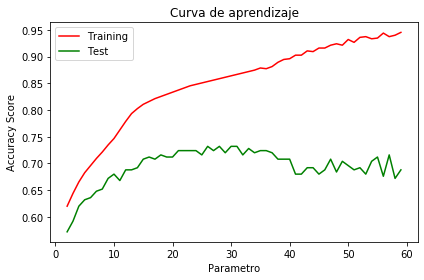

In [140]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **39** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [141]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 39, random_state=0)
tree_classifier.fit(train_vector_data, train_target)

tree_train_predictions = tree_classifier.predict(train_vector_data)
tree_test_predictions = tree_classifier.predict(test_vector_data)

rates.update({'tree_binary_monogram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_binary_monogram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_binary_monogram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.896
Árbol, porcentaje de aciertos en test: 0.708


### 2. Bolsa de palabras con TF-IDF y n-gramas (1,1)

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta la frecuencia de aparición:

In [142]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Una vez generada la bolsa de palabras, convertimos los valores de frecuencia a TF-IDF:

In [143]:
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
print(train_preprocessed.shape)

(750, 1510)


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [144]:
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)
print(test_preprocessed.shape)

(250, 1510)


#### 2.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Gaussiano, ya que estamos teniendo en cuenta un valor continuo como es el TF-IDF.

In [145]:
### GaussianNB no trabaja con matrices dispersas
### Utilizamos la opción partial_fit pasándole fragmentos de la matriz de datos

from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size = 100
num_rows = len(train_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    target_chunk = train_target[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_target))

In [146]:
### GaussianNB no trabaja con matrices disperas, tampoco a la hora de estimar
### Vamos a estimar por trozos y después agregar los resultados

gnb_train_predictions = np.zeros_like(train_target)
gnb_test_predictions = np.zeros_like(test_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows = len(test_target)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)
    
    
rates.update({'gnb_tfidf_monogram': {'Train': np.mean(gnb_train_predictions == train_target),
                                'Test' : np.mean(gnb_test_predictions == test_target)}})
    
print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['gnb_tfidf_monogram']['Train'])
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", rates['gnb_tfidf_monogram']['Test'])

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9106666666666666
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.612


- Este clasificador nos da unos malos resultados porque los datos no siguen una distribución normal, sino que siguen una distribución asimétrica a la derecha: 

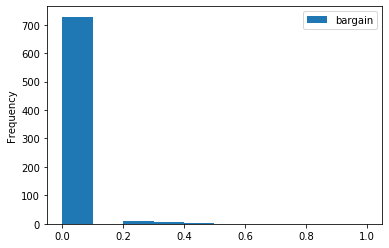

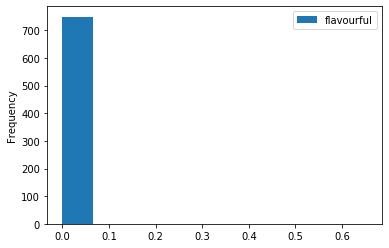

In [147]:
import pandas as pd

term=pd.DataFrame(data= train_preprocessed[:,381].toarray(), columns=[feature_names[100]])
term.plot.hist()

term=pd.DataFrame(data= train_preprocessed[:,500].toarray(), columns=[feature_names[500]])
term.plot.hist()

#### 2.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [148]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 70)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(max_depth=md)
    tree_classifier.fit(train_preprocessed, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

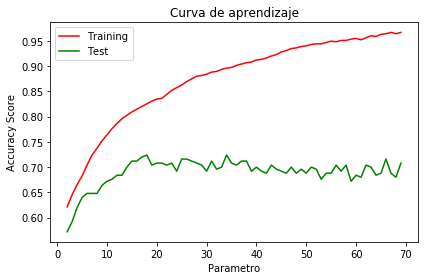

In [149]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **17** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [150]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(train_preprocessed, train_target)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

rates.update({'tree_tfidf_monogram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_tfidf_monogram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_tfidf_monogram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.82
Árbol, porcentaje de aciertos en test: 0.72


### 3. Bolsa de palabras binarias y n-gramas (1,2)

Creamos una bolsa de palabras con bigramas (tenemos en cuenta la probabilidad de una palabra en función de la palabra anterior) y que tenga en cuenta si una palabra aparece o no:

In [151]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [152]:
test_vector_data = vectorizer.transform(test_data)
print(test_vector_data.shape)

(250, 4347)


Con ayuda de la función ```write_terms```, podemos ver algunos ejemplos de como se han vectorizado los mensajes.  
> A diferencia de los dos casos anteriores, aquí usamos bigramas. Vemos como eso hace que aumente el número de términos (antes 1510, ahora 4347) y podemos ver en los mensajes vectorizados que ahora algunos terminos constan de dos palabras:

In [153]:
write_terms(feature_names, train_data, train_vector_data, 1)
write_terms(feature_names, train_data, train_vector_data, 10)
write_terms(feature_names, train_data, train_vector_data, 100)

Mensaje 1 : And the chef was generous with his time (even came around twice so we can take pictures with him).
Mensaje 1 vectorizado: ['came' 'came twice' 'chef' 'chef generous' 'generous' 'generous time'
 'pictures' 'time' 'time came' 'twice' 'twice pictures'] 

Mensaje 10 : The cashew cream sauce was bland and the vegetables were undercooked.
Mensaje 10 vectorizado: ['bland' 'bland vegetables' 'cashew' 'cashew cream' 'cream' 'cream sauce'
 'sauce' 'sauce bland' 'undercooked' 'vegetables' 'vegetables undercooked'] 

Mensaje 100 : Now this dish was quite flavourful.
Mensaje 100 vectorizado: ['dish' 'dish quite' 'flavourful' 'quite' 'quite flavourful'] 



#### 3.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Multinomial (Binarizado), que es útil cuando lo que estamos teniendo en cuenta es la aparición de las palabras, independientemente de su frecuencia.

In [154]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

rates.update({'mnb_binary_bigram': {'Train': np.mean(mnb_train_predictions == train_target),
                                'Test' : np.mean(mnb_test_predictions == test_target)}})

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:",rates['mnb_binary_bigram']['Train'])
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", rates['mnb_binary_bigram']['Test'])

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9786666666666667
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.732


#### 3.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [155]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 60)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(max_depth=md)
    tree_classifier.fit(train_vector_data, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_vector_data)
    tree_test_predictions = tree_classifier.predict(test_vector_data)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

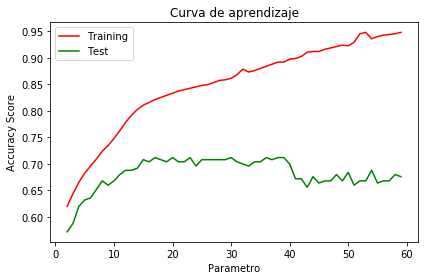

In [156]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **38** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [157]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 38, random_state=0)
tree_classifier.fit(train_vector_data, train_target)

tree_train_predictions = tree_classifier.predict(train_vector_data)
tree_test_predictions = tree_classifier.predict(test_vector_data)

rates.update({'tree_binary_bigram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_binary_bigram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_binary_bigram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.8946666666666667
Árbol, porcentaje de aciertos en test: 0.704


### 4. Bolsa de palabras con TF-IDF y n-gramas (1,2)

Creamos una bolsa de palabras con bigramas (tenemos en cuenta la probabilidad de una palabra en función de la palabra anterior) y que tenga en cuenta la frecuencia de aparición:

In [158]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,2))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


Una vez generada la bolsa de palabras, convertimos los valores de frecuencia a TF-IDF:

In [159]:
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
print(train_preprocessed.shape)

(750, 4347)


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [160]:
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)
print(test_preprocessed.shape)

(250, 4347)


#### 4.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Gaussiano, ya que estamos teniendo en cuenta un valor continuo como es el TF-IDF.

In [161]:
### GaussianNB no trabaja con matrices dispersas
### Utilizamos la opción partial_fit pasándole fragmentos de la matriz de datos

from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size = 100
num_rows = len(train_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    target_chunk = train_target[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_target))

In [162]:
### GaussianNB no trabaja con matrices disperas, tampoco a la hora de estimar
### Vamos a estimar por trozos y después agregar los resultados

gnb_train_predictions = np.zeros_like(train_target)
gnb_test_predictions = np.zeros_like(test_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows = len(test_target)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)
    
rates.update({'gnb_tfidf_bigram': {'Train': np.mean(gnb_train_predictions == train_target),
                                'Test' : np.mean(gnb_test_predictions == test_target)}})    

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['gnb_tfidf_bigram']['Train'])
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", rates['gnb_tfidf_bigram']['Test'])

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9346666666666666
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.616


- Este clasificador nos da unos malos resultados porque los datos no siguen una distribución normal, sino que siguen una distribución asimétrica a la derecha: 

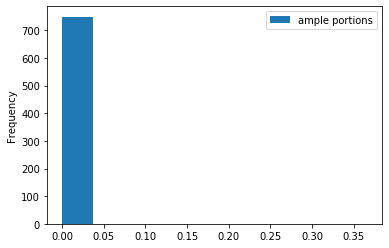

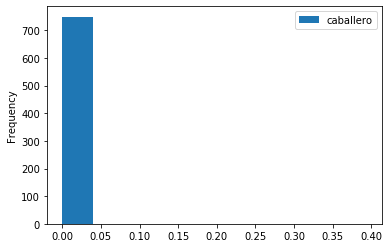

In [163]:
import pandas as pd

term=pd.DataFrame(data= train_preprocessed[:,381].toarray(), columns=[feature_names[100]])
term.plot.hist()

term=pd.DataFrame(data= train_preprocessed[:,500].toarray(), columns=[feature_names[500]])
term.plot.hist()

#### 4.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [164]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 70)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(max_depth=md)
    tree_classifier.fit(train_preprocessed, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

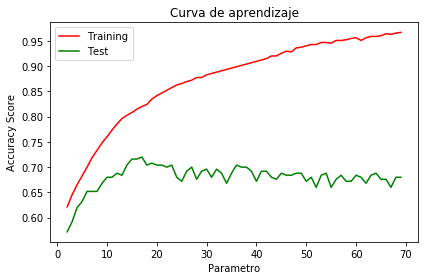

In [165]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **17** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [166]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(train_preprocessed, train_target)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

rates.update({'tree_tfidf_bigram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_tfidf_bigram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_tfidf_bigram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.82
Árbol, porcentaje de aciertos en test: 0.72


### Comparación:

- Comprobamos los porcentajes de aciertos para cada conficuración elegida:

In [167]:
i = 0
for a, b in rates.items():
    print(a, b)
    if(i%2 != 0):
        print('----------------------')
    i = i + 1

mnb_binary_monogram {'Train': 0.9573333333333334, 'Test': 0.728}
tree_binary_monogram {'Train': 0.896, 'Test': 0.708}
----------------------
gnb_tfidf_monogram {'Train': 0.9106666666666666, 'Test': 0.612}
tree_tfidf_monogram {'Train': 0.82, 'Test': 0.72}
----------------------
mnb_binary_bigram {'Train': 0.9786666666666667, 'Test': 0.732}
tree_binary_bigram {'Train': 0.8946666666666667, 'Test': 0.704}
----------------------
gnb_tfidf_bigram {'Train': 0.9346666666666666, 'Test': 0.616}
tree_tfidf_bigram {'Train': 0.82, 'Test': 0.72}
----------------------


 #### ¿Hay un clasificador que sea superior al otro? ¿por qué crees que sucede?


Como hemos mencionado antes, el Naive Bayes Gausiano da los peores resultados pero se debe a la asimetría de los datos. 

Entre el resto de clasificadores podemos observar que los resultados del test no varían tanto, pero obtenemos resultados algo mejores, tanto en entrenamiento como en test, con el clasificador Naive Bayes Multinomial.  

El árbol de decisión funciona medianamente bien en todos los casos ya que es un clasificador bastante general, sin embargo para esto han sido necesarios mecanismos de poda para evitar sobreaprendizaje.   
Por otro lado, mientras que en el arbol de decisión se van eligiendo palabras una a una para ir separando clases, en el Naive Bayes se tiene en cuenta la probabiblidad de cada palabra de aparecer en cada clase, lo cuál permite calcular más fácilmente a que clase pertenece cada ejemplo.

#### Para cada clasificador, ¿tiene un efecto positivo el añadir “complejidad” a la vectorización? Es decir, añadir bigramas y añadir tf-idf. ¿Por qué crees que sucede este efecto positivo o la falta del mismo? ###

Para el clasificador Naive Bayes hay una ligera mejoría si aumentamos la complejidad de los n-gramas. Esto se debe a que con bigramas tenemos en cuenta más combinaciones de palabras y su probabilidad de aparecer en una clase u otra.   
Pero al cambiar la frecuencia binaria por TF-IDF, como usamos un Naive Bayes Gausiano obtenemos peores resultados.

En los arboles de decision, si usamos frecuencia binaria, empeoran en resultados de test al añadir bigramas.   
Añadiendo TF-IDF conseguimos mejores resultados, independientemente de la complejidad de los n-gramas. Esta mejora se debe a que los arboles de decision pueden ver que variables tienen más peso con más facilidad, ya que no solo saben si aparecen o no sino cuántas veces aparecen.

Podemos concluir que podemos mejorar los resultados del Naive Bayes si aumentamos la complejidad de los n-gramas, y podemos mejorar los arboles si usamos TF-IDF en lugar de valores binarios.

#### Selecciona el mejor árbol de decisión y obtén las 25 variables con más poder discriminante: ¿Predominan más las palabras de uno u otro sentimiento? ¿por qué? ¿hay ruido? ###

Seleccionamos cualquiera de los dos árboles de decisión que tengan en cuenta la frecuencia TF/IDF, en este caso cogemos el árbol de decisión con monogramas (ya que queremos analizar las 25 variables con mayor poder discriminante y al ser monogramas estas seran una palabra en vez de poder ser una o dos)

In [168]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))

tfider = TfidfTransformer()
tree_train_vector_data = vectorizer.fit_transform(train_data)
tree_train_preprocessed = tfider.fit_transform(tree_train_vector_data)

tree_test_vector_data = vectorizer.transform(test_data)
tree_test_preprocessed = tfider.transform(tree_test_vector_data)

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(tree_train_preprocessed, train_target)

tree_feature_names = vectorizer.get_feature_names()

# Hacemos las predicciones (las usaremos en el siguiente apartado)
tree_train_predictions = tree_classifier.predict(tree_train_preprocessed)
tree_test_predictions = tree_classifier.predict(tree_test_preprocessed)

In [169]:
def print_top25_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names()
    
    top25 = np.argsort(clf.feature_importances_)[-25:]
    reversed_top = top25[::-1]
    print("Top 25 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

print_top25_features_in_trees(vectorizer,tree_classifier)

Top 25 features in the tree

great / good / amazing / best / delicious / friendly / nice / fantastic / loved / awesome / love / perfect / happy / restaurant / excellent / enjoyed / definitely / way / don / quickly / pale / recent / beans / kabuki / par


Claramente predominan las palabras de sentimiento positivo, esto se puede deber a que estas palabras sólo estarán en mensajes con sentimiento positivo y muy difícilmente aparecerán en mensajes negativos.  
Hay algo de ruido, encontramos palabras que no denotan ningún sentimiento específico como "par", "way" o "restaurant".

#### Selecciona el mejor clasificador naive bayes y obtén las 25 variables con más presencia en cada clase:¿Tienen sentido las palabras seleccionadas? ¿hay ruido (palabras sin sentimiento o de sentimiento opuesto al esperado)? ¿por qué crees que suceden estos fenómenos?

El mejor clasificador naive bayes que hemos obtenido es el que utiliza la frecuencia binaria y bigramas con un una precision en test de un 73,2%

In [179]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2)) 

mnb_train_vector_data = vectorizer.fit_transform(train_data)
mnb_test_vector_data = vectorizer.transform(test_data)

mnb_classifier = MultinomialNB()
mnb_classifier.fit(mnb_train_vector_data, train_target)

mnb_feature_names = vectorizer.get_feature_names()

# Hacemos las predicciones (las usaremos en el siguiente apartado)
mnb_train_predictions = mnb_classifier.predict(mnb_train_vector_data)
mnb_test_predictions = mnb_classifier.predict(mnb_test_vector_data)

In [171]:
def print_top25_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 25 features per class\n")
    for i, class_label in enumerate(class_labels):
        top25 = np.argsort(clf.feature_log_prob_[i])[-25:]
        reversed_top = top25[::-1]
        print("%s:   %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
print_top25_features_per_class_in_NB(vectorizer,mnb_classifier,class_labels = [0,1])  

Top 25 features per class

0:   food / place / service / like / don / good / won / ve / time / bad / disappointed / really / worst / just / wasn / minutes / did / got / going / eat / think / terrible / came / probably / times 

1:   good / great / food / place / service / really / best / amazing / just / nice / friendly / time / delicious / love / menu / staff / awesome / restaurant / like / vegas / pizza / definitely / experience / loved / perfect 



Podemos ver que hay varias palabras que las dos clases comparten (food, time, place, service) que son palabras muy comunes para valorar un restaurante (la comida, el servicio, el tiempo de espera o la decoracion del sitio) pero no denotan ningún sentimiento implícito, se usan para acompañar a los adjetivos que sí denotan sentimiento.

- En la clase 0 (sentimiento negativo) podemos ver la palabra _good_ que en principio denota un sentimiento positivo pero como tambien hay presencia de negativas (bad, disappointed, worst...), puede que simplemente esté presente junto a una negación. Además hay algo de ruido, aparte de las variables repetidas en ambas clases, como la palabra _think_ que simplemente sirve para expresar una opinión.

- En la clase 1 (sentimiento positivo) no encontramos ninguna palabra que en principio exprese sentimiento negativo pero si encontramos algo de ruido como _experience_ o _menu_ que no denota ningún sentimiento. Sin embargo, como la gran mayoría son adjetivos positivos es bastante seguro asumir que este 'ruido' viene acompañado de estos para expresar un sentimiento positivo. Además tenemos la palabra _pizza_ que podría significar que es un plato que suele gustar.

#### Conclusiones

- Los árboles de decisión sirven bastante bien para este problema ya que son un clasificador bastante genérico y polivalente. Además no influye demasiado el uso de monogramas o bigramas, pero si mejora los resultados el usar TF-IDF en vez de valores bianrios ya que el clasificador puede decidir mejor que variables son más relevantes.
- El Naive Bayes (Multinomial) obtiene resultados algo mejores que el árbol ya que tiene en cuenta todas las palabras a la vez y decide en función de la probabilidad que tiene cada una de aparecer en cada clase.

> De esto podemos concluir que añadir complejidad, TF-IDF o bigramas, puede resultar útil pero depende del tipo de clasificador que usemos será mejor una cosa o la otra.

- Por lo general, las variables que denotan sentimiento positivo tiene más peso, esto se puede deber a que es más difícil que aparezcan palabras positivas en textos con intención negativa.
Además la mayoría de las variables significantes son adjetivos, que obviamente sirven específicamente para describir sentimientos.

## B) Evaluación detallada

Para evaluar mejor los resultados anteriores vamos a seleccionar el clasificador Naive Bayes Multinomial binario, con bigramas y el árbol de decisión con TF-IDF y monogramas. Vamos a analizar los resultados de estos dos clasificadores en test.

In [172]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['Negativo', 'Positivo']

- Naive Bayes Multinomial (bigramas, binario):

In [173]:
class_report = classification_report(test_target, mnb_test_predictions, target_names=target_names)
conf_matrix = confusion_matrix(test_target, mnb_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)
print("Clasificador Naive Bayes: ")
print(class_report)
print("Matriz de confusion: ")
print(conf_matrix_df)

Clasificador Naive Bayes: 
              precision    recall  f1-score   support

    Negativo       0.73      0.68      0.70       117
    Positivo       0.74      0.77      0.75       133

    accuracy                           0.73       250
   macro avg       0.73      0.73      0.73       250
weighted avg       0.73      0.73      0.73       250

Matriz de confusion: 
          Negativo  Positivo
Negativo        80        37
Positivo        30       103


- Árbol de decisión (monogramas, TF-IDF):

In [174]:
class_report = classification_report(test_target, tree_test_predictions, target_names=target_names)
conf_matrix = confusion_matrix(test_target, tree_test_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)
print("Clasificador Arbol de decisión: ")
print(class_report)
print("Matriz de confusion: ")
print(conf_matrix_df)

Clasificador Arbol de decisión: 
              precision    recall  f1-score   support

    Negativo       0.63      0.97      0.76       117
    Positivo       0.94      0.50      0.66       133

    accuracy                           0.72       250
   macro avg       0.79      0.73      0.71       250
weighted avg       0.80      0.72      0.71       250

Matriz de confusion: 
          Negativo  Positivo
Negativo       113         4
Positivo        66        67


- Para el Naive Bayes obtenemos prácticamente los mismos resultados para ambas clases, aunque existe una exhaustividad algo más baja en los mensajes de sentimiento negativo lo cuál indica que el clasificador tiende a confudirlos con mensajes positivos (esto puede deberse a lo visto anteriormente, para la clase negativa el clasificador tenía en cuenta palabras como 'good' que en principio denotan sentimiento positivo)

- Para el Árbol de Decisión hay bastante diferencia entre ambas clases.   
Para la clase negativa tenemos una precisión bastante baja pero una exhaustividad muy alta. Esto puede significar que no encuentra rasgos que distingan bien a los mensajes negativos y por tanto encuentra gran parte de ellos pero a su vez hay muchos falsos negativos.
En cambio para la clase positiva tiene muy buena precisión pero una exhaustividad muy baja. Podemos ver en la matriz de confusión que hay muy pocos falsos positivos, sin embargo muchos mensajes positivos se confunden con menasajes negativos.   
(Como hemos visto en el apartado anterior, las variables más significativas para el árbol son todas de carácter positivo, esto puede explicar como tiene mucha precisión con los positivos pero si un positivo no tiene esas palabras puede confundirlo con un negativo)

Podemos ver que aunque los dos clasificadores tienen casi la misma precisión en general (el Naive Bayes falla en 67 casos de 250 y el Árbol en 70 de 250) el numero de falsos positivos y el de falsos negativos varía mucho entre los clasificadores.
El Naive Bayes es un mucho más homogéneo y obtiene unos resultados más balanceados para ambas clases (como podemos observar en el ratio de falsos positivos/falsos negativos)   
En cambio el arbol de decisión solo resulta en 4 casos de falsos positivos mientras que el numero de falsos negativos se dispara con 66 casos, por lo que está mucho más desbalanceado y muchos mensajes positivos se clasifican mal.   
 
Los dos tienen más precisión al clasificar la clase positiva, pero la diferencia en el naive bayes es nimia y en el árbol de decisión esto se paga con muy baja exhaustividad asi que realmente no podemos concluir que los dos clasificadores clasifican mejor una clase que otra.

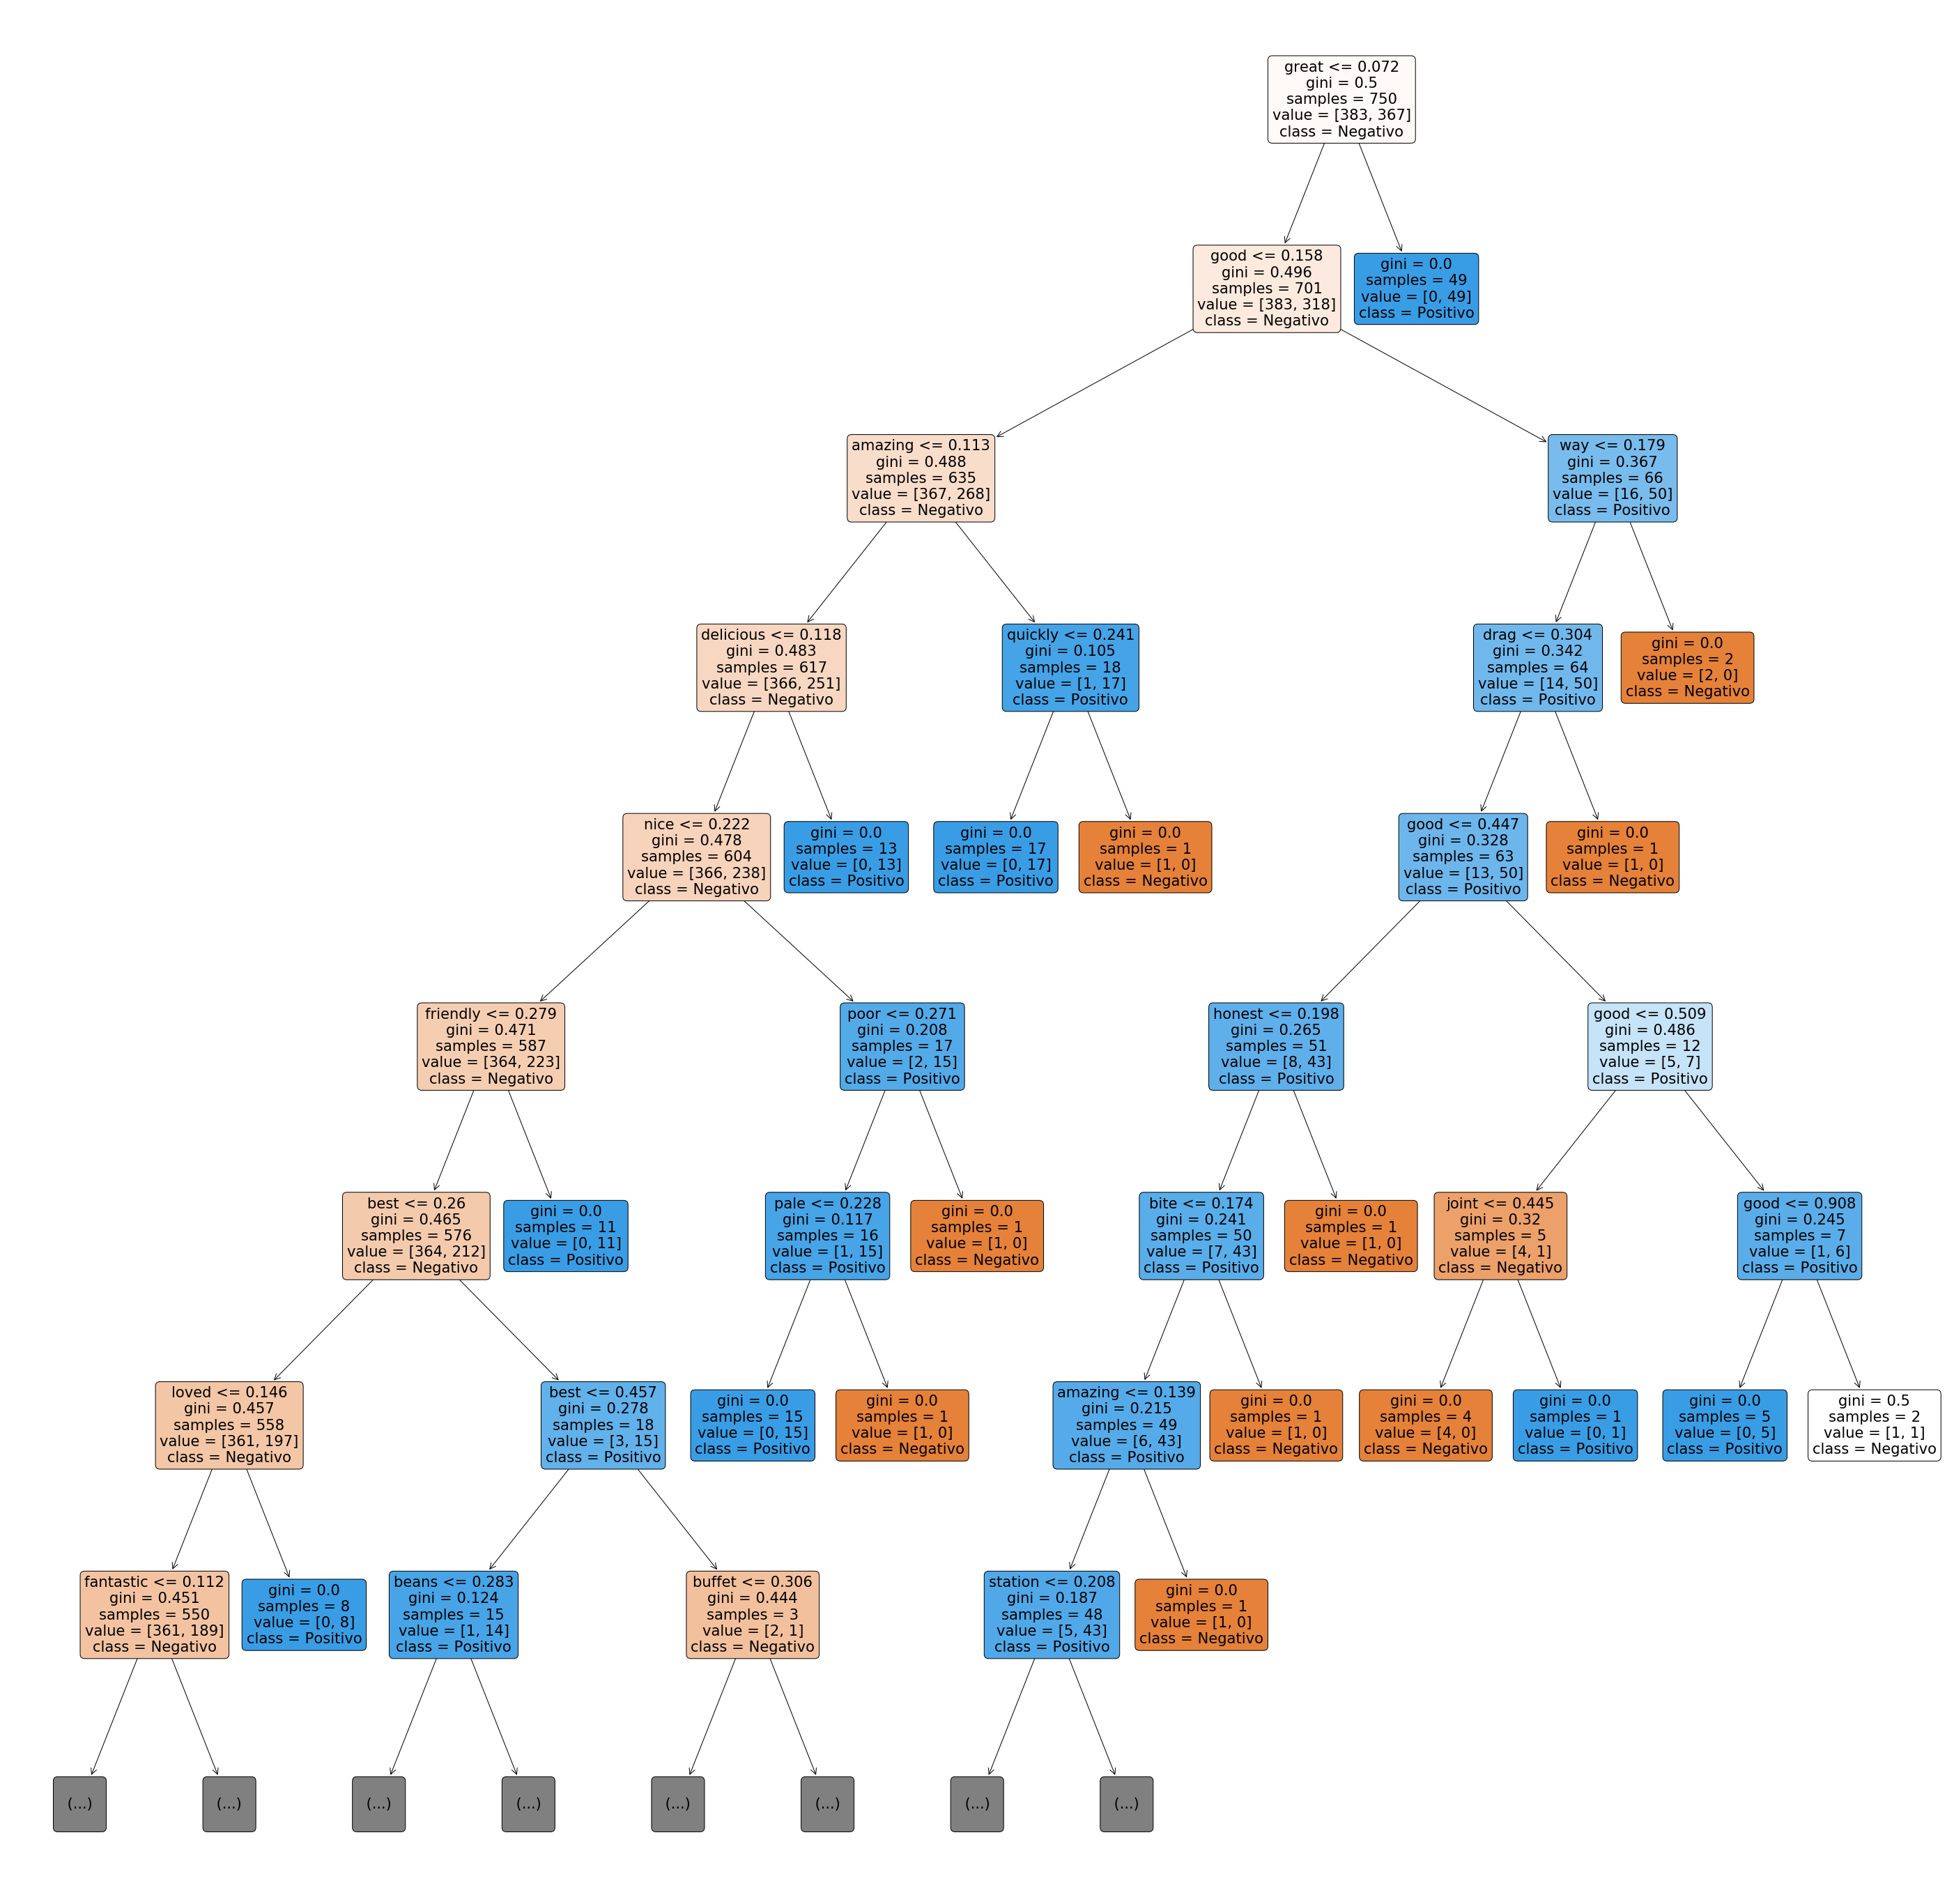

In [175]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50,50))
plot_tree(tree_classifier, filled=True, feature_names=tree_feature_names ,class_names=target_names, max_depth = 8, rounded=True)
plt.savefig('Tree.pdf')
plt.show()
# plot_tree(tree_classifier, max_depth = 8)

#### Finalmente, vamos a ver algunos ejemplos de fallos en cada clasificador:

- **Naive Bayes Multinomial**:

In [176]:
falsos_negativos = np.where((mnb_test_predictions == 0) & (mnb_test_predictions != test_target))
falsos_positivos = np.where((mnb_test_predictions == 1) & (mnb_test_predictions != test_target))

print('Falsos Negativos: ', falsos_negativos)
print('Falsos Positivos:', falsos_positivos)

Falsos Negativos:  (array([ 26,  33,  42,  51,  56,  64,  67,  76,  97, 100, 104, 109, 110,
       126, 129, 140, 149, 151, 163, 169, 179, 185, 194, 221, 224, 226,
       229, 236, 238, 248], dtype=int64),)
Falsos Positivos: (array([  0,   2,   5,  12,  17,  23,  29,  38,  46,  55,  62,  63,  75,
        80,  86,  89,  96,  99, 103, 105, 113, 121, 123, 127, 146, 154,
       159, 166, 192, 209, 222, 227, 228, 233, 235, 246, 247], dtype=int64),)


In [189]:
print("Falsos Negativos:")
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 110)
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 33)
print("Falsos Positivos:")
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 5)
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 235)

Falsos Negativos:
Mensaje 110 : Food arrived quickly!
Mensaje 110 vectorizado: ['arrived' 'food' 'quickly'] 

Mensaje 33 : When I received my Pita it was huge it did have a lot of meat in it so thumbs up there.
Mensaje 33 vectorizado: ['did' 'huge' 'lot' 'meat' 'pita' 'received' 'thumbs'] 

Falsos Positivos:
Mensaje 5 : The ambiance isn't much better.
Mensaje 5 vectorizado: ['ambiance' 'better'] 

Mensaje 235 : There is so much good food in Vegas that I feel cheated for wasting an eating opportunity by going to Rice and Company.
Mensaje 235 vectorizado: ['company' 'eating' 'feel' 'food' 'food vegas' 'going' 'good' 'good food'
 'opportunity' 'rice' 'vegas' 'wasting'] 



> - En los dos ejemplos de falsos negativos vemnos que no aparece casi ninguna de las palabras significativas de la clase positiva (palabras como _good, amazing, delicious..._) lo cual ha hecho que se clasifiquen como negativas.  
- En el primer ejemplo de falso positivo tenemos la palabra better que puede que se haya relacionado con sentimiento positivo. En el segundo ejemplo habla de buena comida al principio a pesar de que la verdadera opinión está al final, debido a eso el uso de palabras como _good_ o _good food_ junto a otras que no denotan ningun sentimiento concreto (_food_ o _rice_) han llevado a una mala clasifiación.

- **Árbol de decisión:**

In [190]:
falsos_negativos = np.where((tree_test_predictions == 0) & (tree_test_predictions != test_target))
falsos_positivos = np.where((tree_test_predictions == 1) & (tree_test_predictions != test_target))

print('Falsos Negativos: ', falsos_negativos)
print('Falsos Positivos:', falsos_positivos)

Falsos Negativos:  (array([  9,  21,  26,  30,  31,  32,  33,  40,  42,  51,  56,  57,  59,
        64,  66,  67,  68,  73,  76,  79,  82,  84,  91,  95,  97,  98,
       100, 101, 106, 109, 110, 111, 114, 119, 120, 126, 129, 147, 148,
       149, 150, 151, 157, 163, 169, 172, 175, 185, 187, 194, 197, 199,
       204, 213, 218, 221, 226, 229, 230, 231, 232, 236, 237, 238, 245,
       248], dtype=int64),)
Falsos Positivos: (array([ 29,  47,  90, 235], dtype=int64),)


In [195]:
print("Falsos Negativos:")
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 21)
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 129)
print("Falsos Positivos:")
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 47)
write_terms(mnb_feature_names, test_data, mnb_test_vector_data, 29)

Falsos Negativos:
Mensaje 21 : This place is a jewel in Las Vegas, and exactly what I've been hoping to find in nearly ten years living here.
Mensaje 21 vectorizado: ['place' 've' 'vegas' 'years'] 

Mensaje 129 : We made the drive all the way from North Scottsdale... and I was not one bit disappointed!
Mensaje 129 vectorizado: ['bit' 'disappointed' 'drive' 'way'] 

Falsos Positivos:
Mensaje 47 : The waiter wasn't helpful or friendly and rarely checked on us.
Mensaje 47 vectorizado: ['checked' 'friendly' 'helpful' 'rarely' 'waiter' 'wasn'] 

Mensaje 29 : Crust is not good.
Mensaje 29 vectorizado: ['crust' 'good'] 



mgreat / good / amazing / best / delicious / friendly / nice / fantastic / loved / awesome / love / perfect / happy / restaurant / excellent / enjoyed / definitely / way / don / quickly / pale / recent / beans / kabuki / par

> - Antes veíamos que las variables con más peso en el árbol por lo general denotaban sentimiento positivo, por tanto vemos que los dos ejemplos de falsos negativos no contienen ninguna de esas palabras positivas, a pesar de que el mensaje si lo sea. Además vemos en el segundo ejemplo la palabra _disappointed_, pero el clasificador no tiene en cuenta que en el mensaje niega esa palabra (_not disappointed_)
- En los ejemplos de falsos negativos podemos ver que sí aparecen palabras que a primeras pueden ser positivas, el problema es que estas palabras van precedidas de negaciones, cosa que el clasificador no tiene en cuenta.

> 